Lab 4

In [803]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from collections import Counter,defaultdict


## 1. TSP

Wygeneruj chmuręnlosowych punktów w 2D,
a następnie zastosuj algorytm symulowa-nego wyżarzania
do przybliżonego rozwiązania problemu komiwojażera dla tych punk-tów.


In [2]:
def matrix_points(points,n):
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i,n):
            val = np.sqrt((points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2)
            matrix[i][j] = val
            matrix[j][i] = val
    return matrix



In [76]:
def visualization(points):
    df = pd.DataFrame(points,columns = ["X","Y"])
    sns.scatterplot(data = df,x = "X",y="Y")
    plt.show()

DataSets:

In [88]:
n_sets = [45,90,135]
normal_params = [(0.1,0.5),(3,7),(2,4),(1,9)]
points_uniform1 = np.random.uniform(0.1,10,size=[n_sets[0],2])
points_uniform2 = np.random.uniform(0.1,10,size=[n_sets[1],2])
points_uniform3 = np.random.uniform(0.1,10,size=[n_sets[2],2])

points_normal = []
for i in range(len(n_sets)):
    for j in range(len(normal_params)):
        points_normal.append(np.random.normal(normal_params[j][0],normal_params[j][1],size = [n_sets[i],2]))

In [421]:
def generate_groups(n):
    n = n//9
    result, k, mul = list(), 0, 2

    for x in range(3):
        for y in range(3):
            result.extend([[np.random.random() + mul * x, np.random.random() + mul * y] for _ in range(n)])
    np.random.shuffle(result)
    return result

In [422]:
group1 = generate_groups(n_sets[0])
group2 = generate_groups(n_sets[1])
group3 = generate_groups(n_sets[2])
#
# seper

Example of points:

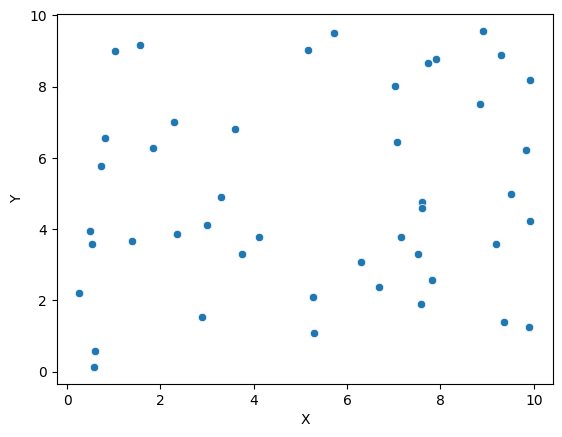

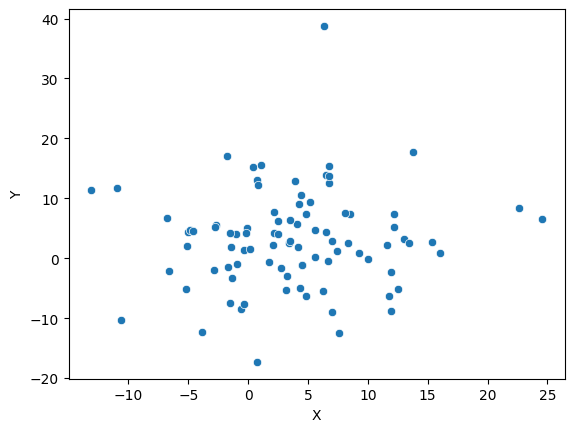

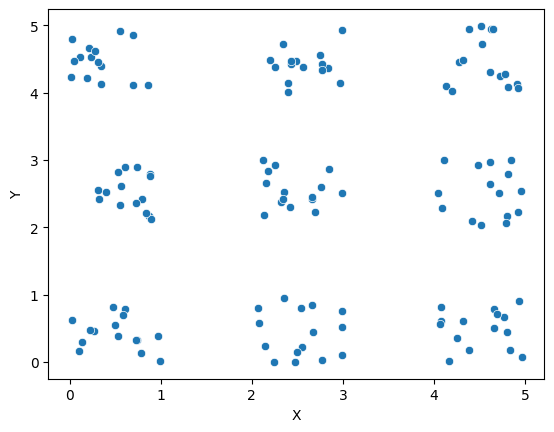

In [91]:
visualization(points_uniform1)
visualization(points_normal[5])
visualization(group3)

Klasy i funkcje do TMP:

In [428]:

class Temperature():
    def __init__(self,iterations,min_temp):
        # Exponential function:
        self.iterations = iterations
        self.min_temp = min_temp
        self.max_temp = 0
        self.temp = 0
        self.diff = abs(self.min_temp) / self.iterations
        self.prob = 1
        self.stash_prob = [self.prob]
        self.mode = self.exp
    def make_linear(self):
        self.mode = self.linear
        self.min_temp = 0
        self.max_temp = self.iterations
        self.temp = self.max_temp
        self.diff = 1

    def linear(self):
        self.temp -= self.diff
        self.prob = self.temp / self.max_temp
    def exp(self):
        self.temp -= self.diff
        self.prob = np.exp(self.temp)
    def calculate_temp(self):
        self.mode()
        self.stash_prob.append(self.prob)

class TSP():
    def __init__(self,points,iterations,method = True,min_temp=-10):
        self.iterations = iterations
        self.Temp = Temperature(iterations,min_temp)
        self.results = []
        self.n = len(points)
        #Default method is set to consecutive swap
        self.method = method
        self.points = [[points[i][0],points[i][1],i] for i in range(self.n)]
        self.matrix = self.make_matrix_of_distance()
        self.best_order = copy.deepcopy(self.points)
        self.best_distance = sum(self.matrix[self.points[i][2]][self.points[(i+1) % self.n][2]] for i in range(self.n))
        self.start_order = copy.deepcopy(self.points)
        self.start_distance = self.best_distance

    def make_matrix_of_distance(self):
        matrix = [[0 for _ in range(self.n)] for _ in range(self.n)]
        for i in range(self.n):
            for j in range(i,self.n):
                val = np.sqrt((self.points[i][0]-self.points[j][0])**2 + (self.points[i][1]-self.points[j][1])**2)
                matrix[i][j] = val
                matrix[j][i] = val
        return np.array(matrix)
    def solve(self):

        current = self.start_distance
        # print(current,self.results)
        self.results.append(current)

        for step in range(self.iterations):
            index1,index2 = np.random.choice(range(self.n),2,replace=False)
            # print(index1,index2)
            if self.method:
                index2 = (index1+1) % self.n

            diff = self.calculate_diff(index1,index2)
            # print(diff)
            rnd = np.random.random()
            if diff > 0 or rnd < self.Temp.prob:

                self.points[index1],self.points[index2] = self.points[index2],self.points[index1]
                current -= diff


            if self.best_distance > current:
                self.best_distance = current

                self.best_order = copy.deepcopy(self.points)

            self.Temp.calculate_temp()
            # print(self.Temp.prob)
            self.results.append(current)


    def calculate_diff(self,index1,index2):
        # print(self.n)
        i_prev1, i_1, i_next1 = self.points[(index1-1) % self.n][2], self.points[index1][2], self.points[(index1+1) % self.n][2]
        i_prev2, i_2, i_next2 = self.points[(index2-1) % self.n][2], self.points[index2][2], self.points[(index2+1) % self.n][2]

        before = self.matrix[i_prev1,i_1] + self.matrix[i_1,i_next1] + self.matrix[i_prev2,i_2] + self.matrix[i_2,i_next2]

        after = self.matrix[i_prev1,i_2] + self.matrix[i_2,i_next1] + self.matrix[i_prev2,i_1] + self.matrix[i_1,i_next2]
        #
        if abs(index1-index2) == 1 or (index1,index2) == (0, self.n-1) or (index1,index2) == (self.n-1,0):
            after += 2*self.matrix[i_1,i_2]

        return before-after
    def initial_plot(self,ax):
        df = pd.DataFrame(self.start_order,columns = ["X","Y","I"])
        sns.scatterplot(ax=ax,data = df,x = "X",y="Y")
        ax.plot([self.start_order[i%self.n][0] for i in range(self.n+1)], [self.start_order[i%self.n][1] for i in range(self.n+1)])
    def ending_plot(self,ax):
        df = pd.DataFrame(self.best_order,columns = ["X","Y","I"])
        sns.scatterplot(ax=ax,data = df,x = "X",y="Y")
        ax.plot([self.best_order[i%self.n][0] for i in range(self.n+1)], [self.best_order[i%self.n][1] for i in range(self.n+1)])
    def probability_plot(self,ax):
        df = pd.DataFrame([[i,self.Temp.stash_prob[i]] for i in range(self.iterations)],columns = ["Iterations","Probability"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Probability")

    def distance_plot(self,ax):
        df = pd.DataFrame([[i,self.results[i]] for i in range(self.iterations)],columns = ["Iterations","Distance"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Distance")
        # plt.show()
    def draw_both(self):
        fig, axes = plt.subplots(2, 2, figsize=(16,12),dpi=70)
        self.initial_plot(axes[0][0])
        axes[0][0].set_title(f'Distance: {self.start_distance}')
        self.ending_plot(axes[0][1])
        axes[0][1].set_title(f'Distance: {self.best_distance}')
        self.distance_plot(axes[1][0])
        self.probability_plot(axes[1][1])
        fig.suptitle('Result')
        plt.show()

In [429]:
def get_answer_TSP(points,number,linear=False,consecutive=True,min_temp = -10):
    #If method = True then consecutive swap is taken
    tsp = TSP(points,number,consecutive,min_temp)
    if(linear):
        tsp.Temp.make_linear()
    tsp.solve()
    tsp.draw_both()

Wizualizacja losowych punktów dla n = 45,90,135:

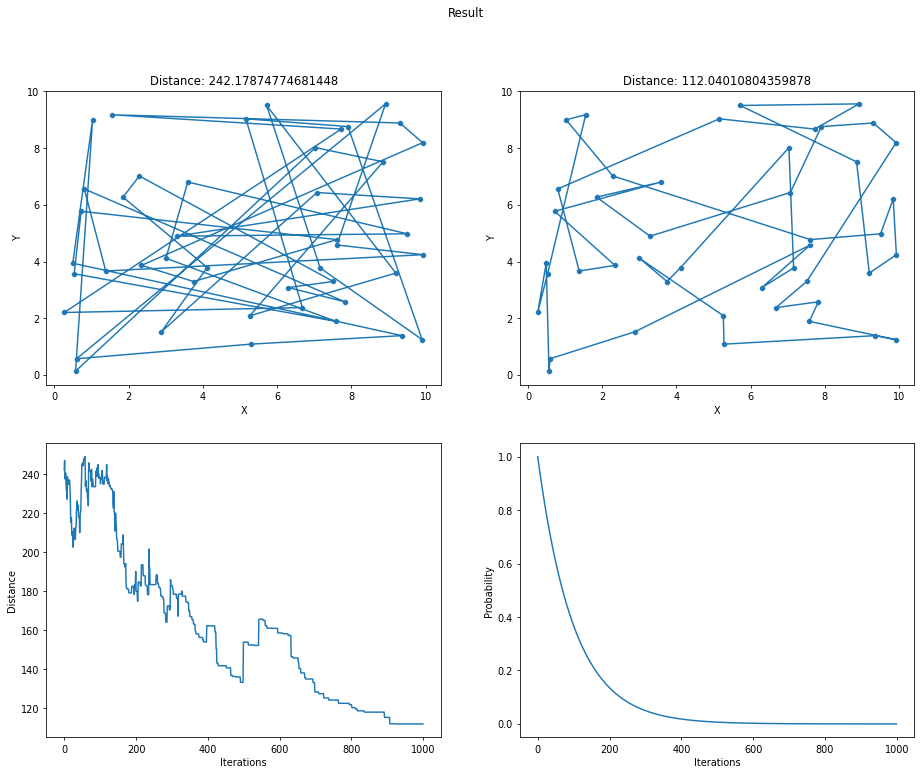

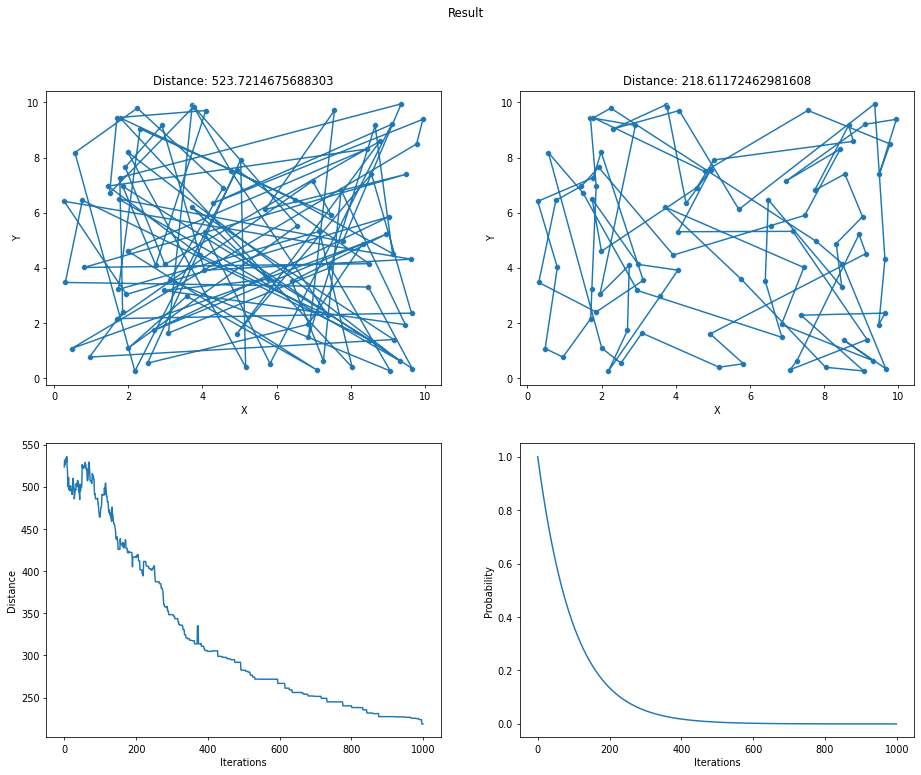

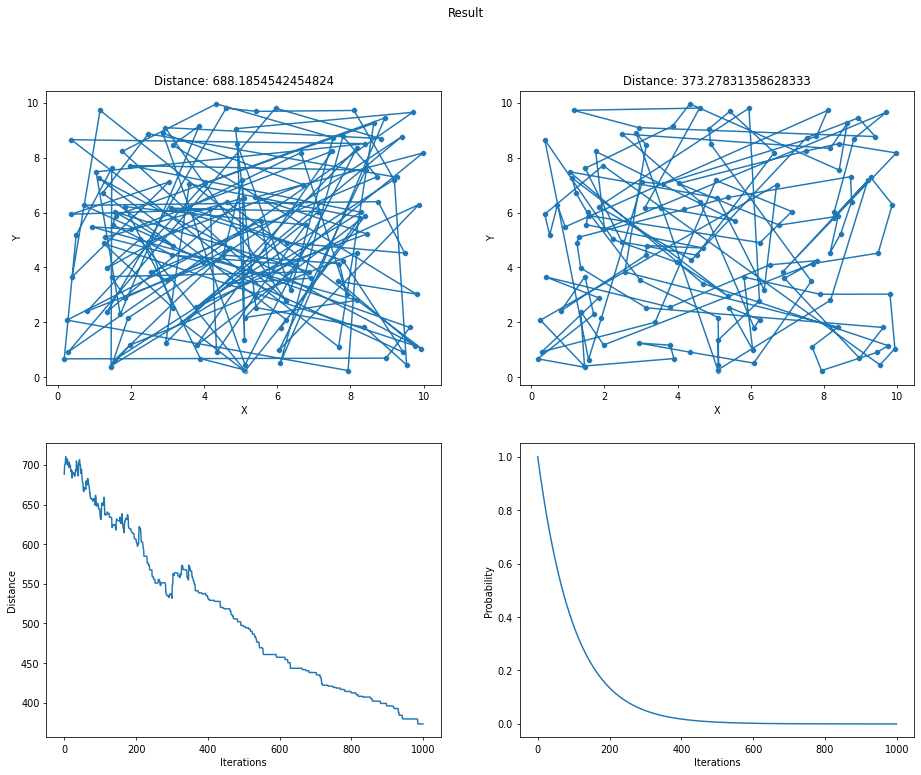

In [405]:
get_answer_TSP(points_uniform1,10**3,linear=False,consecutive=False)
get_answer_TSP(points_uniform2,10**3,linear=False,consecutive=False)
get_answer_TSP(points_uniform3,10**3,linear=False,consecutive=False)

Wizualizacja losowych punktów z rozkładu normalnego dla n = 45,90,135:

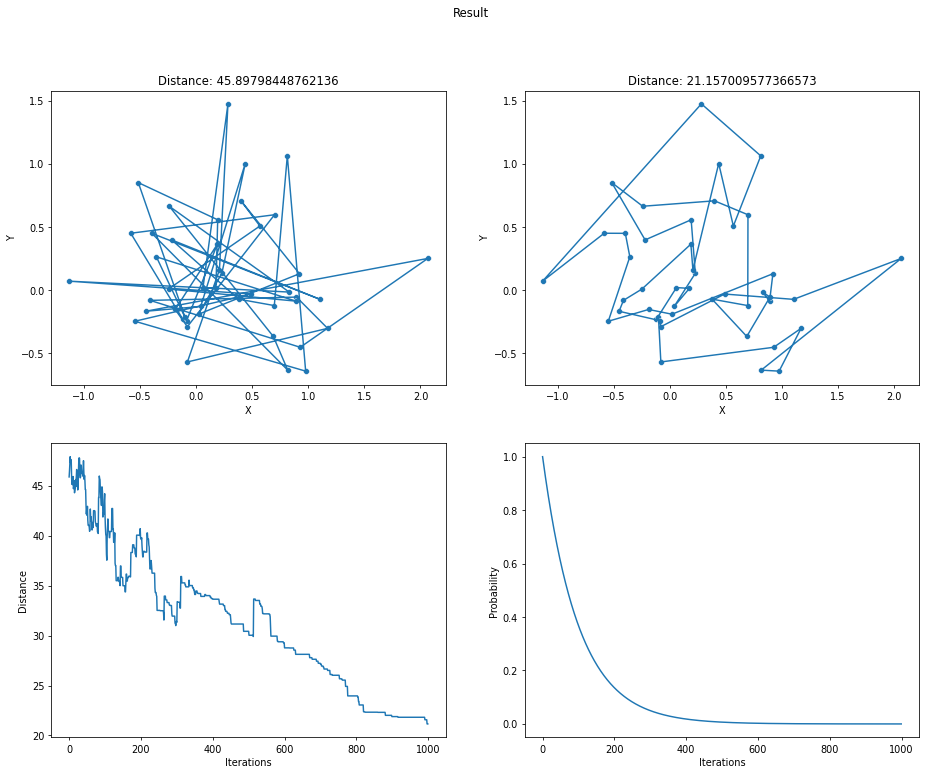

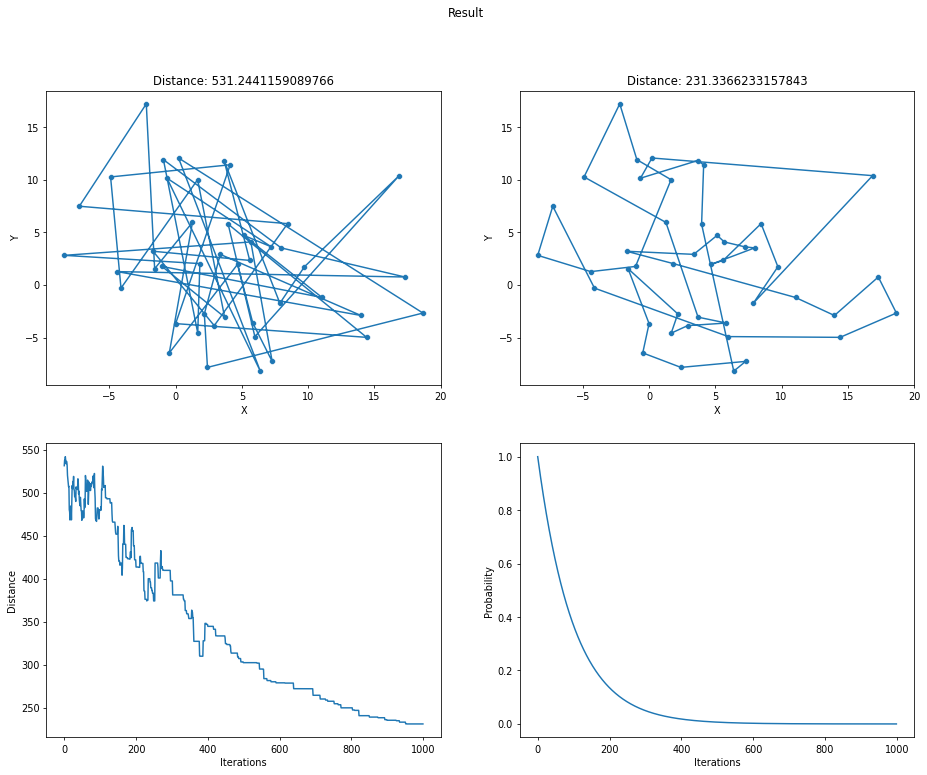

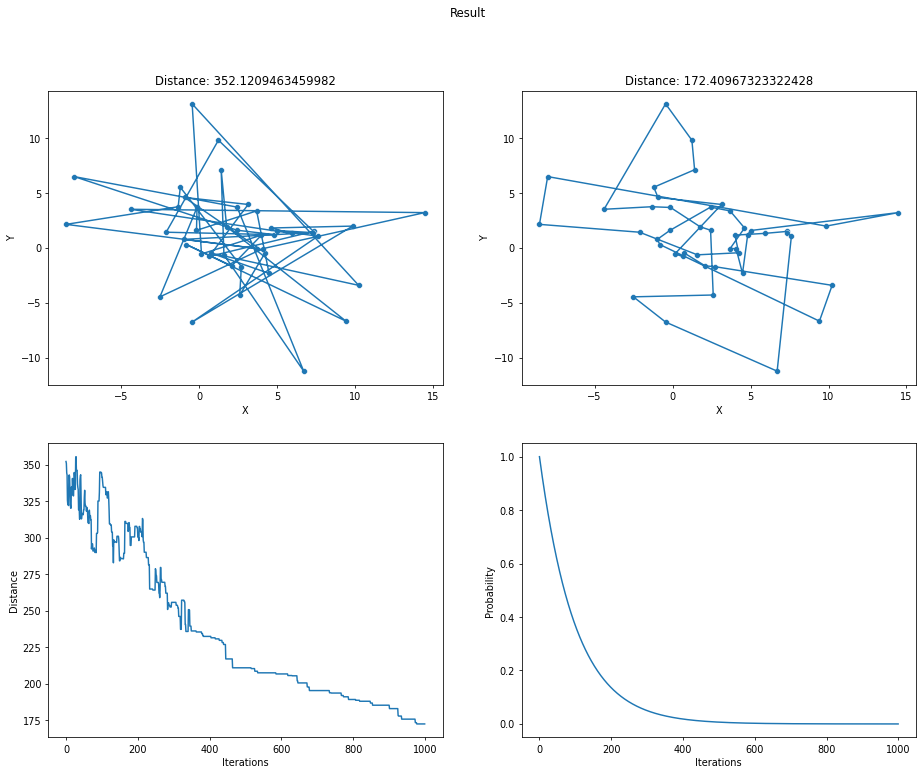

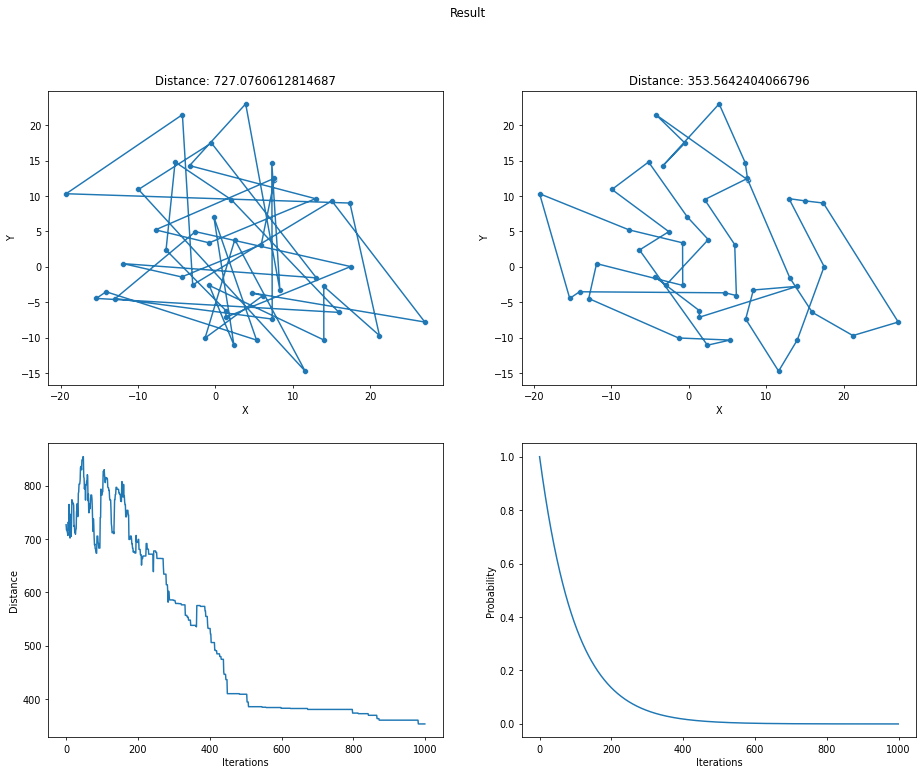

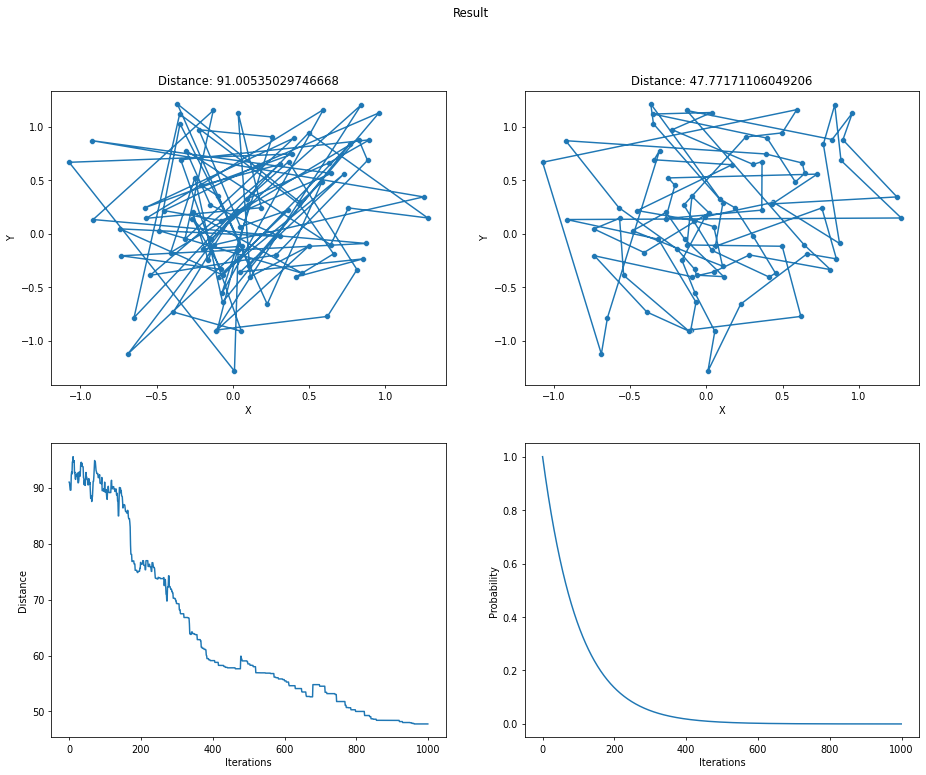

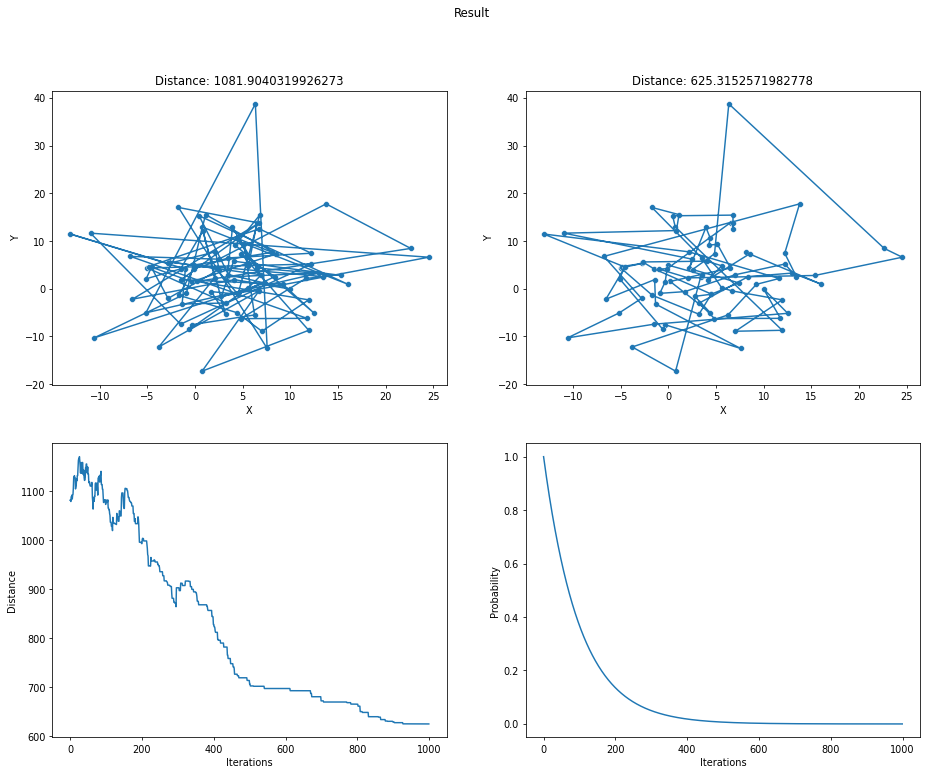

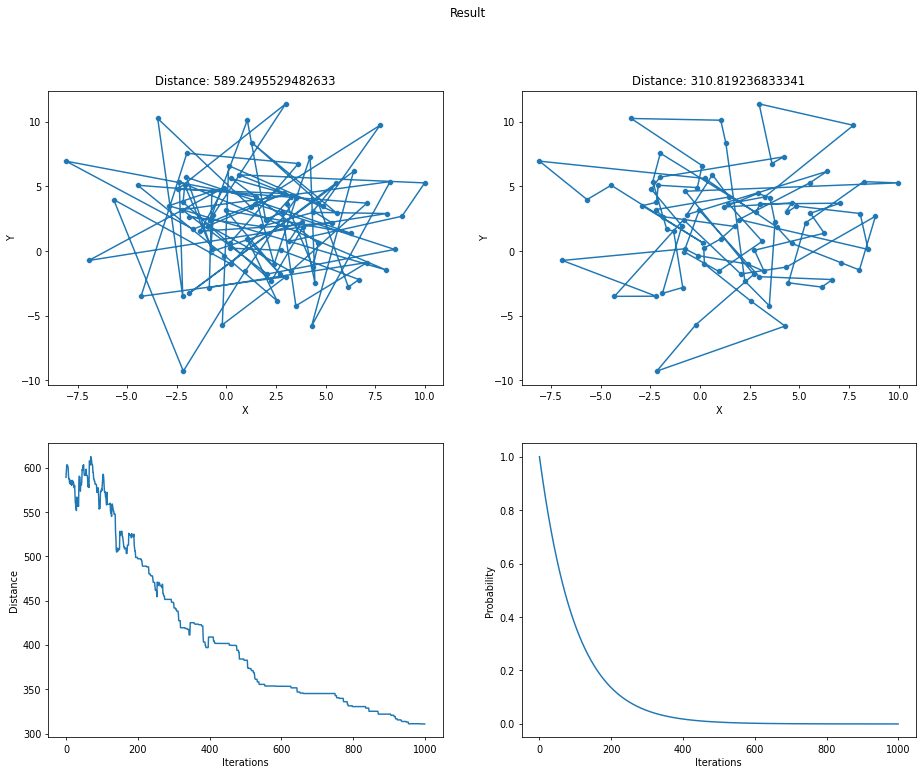

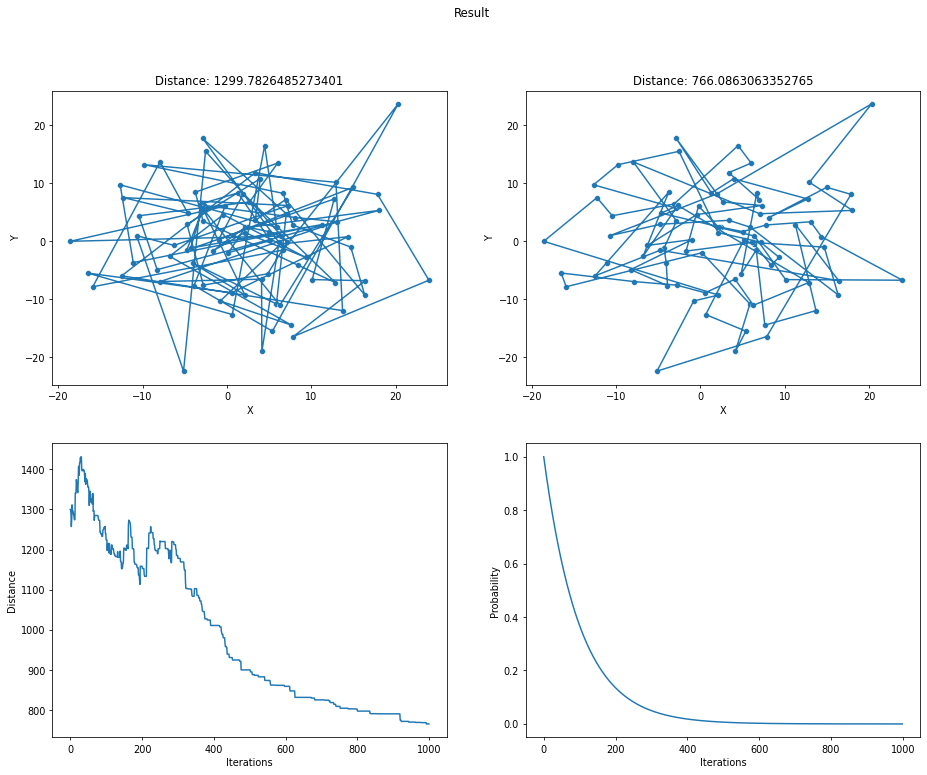

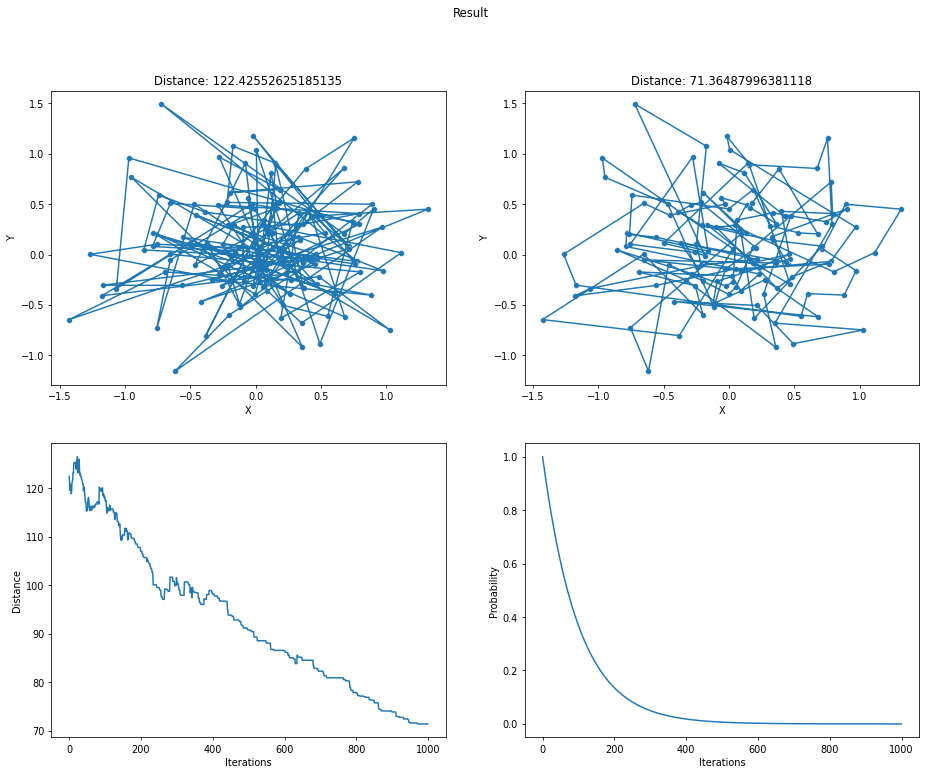

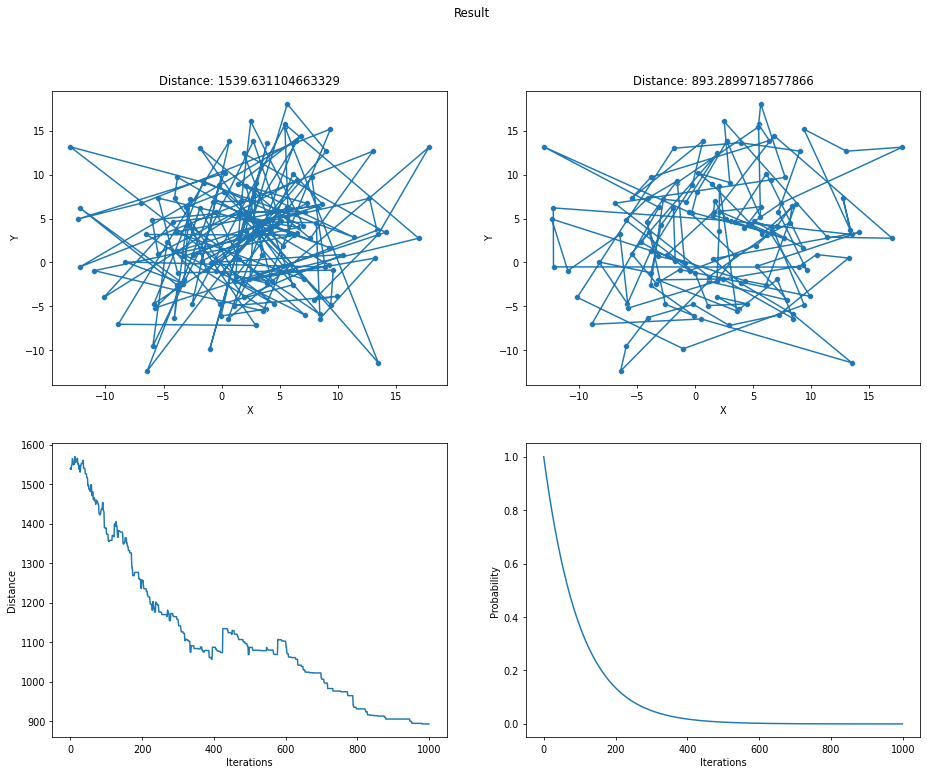

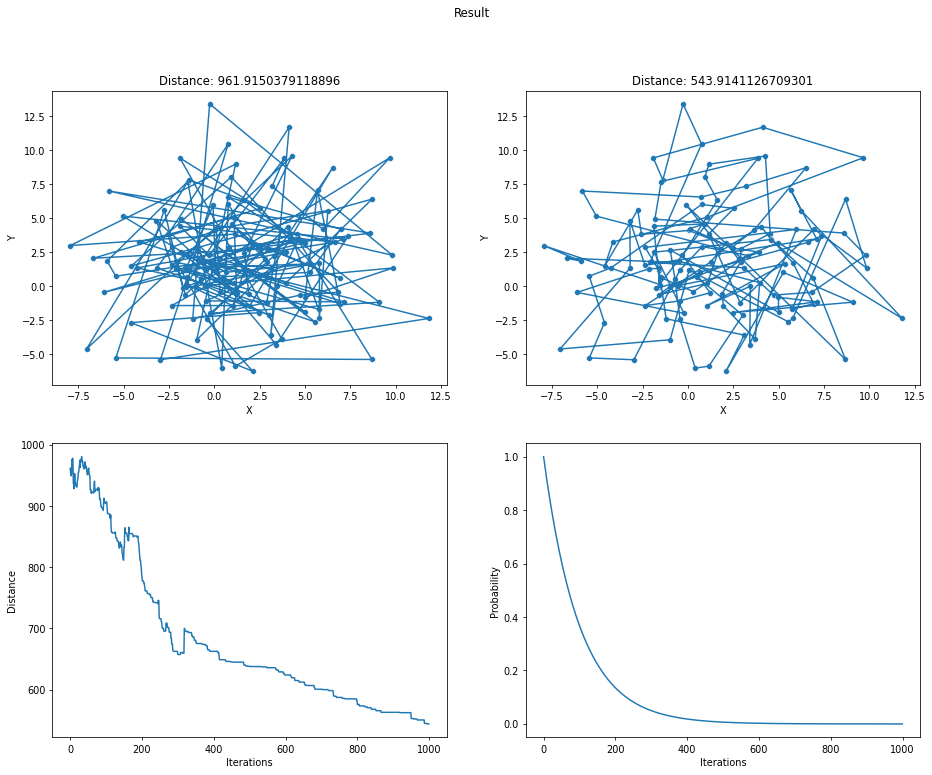

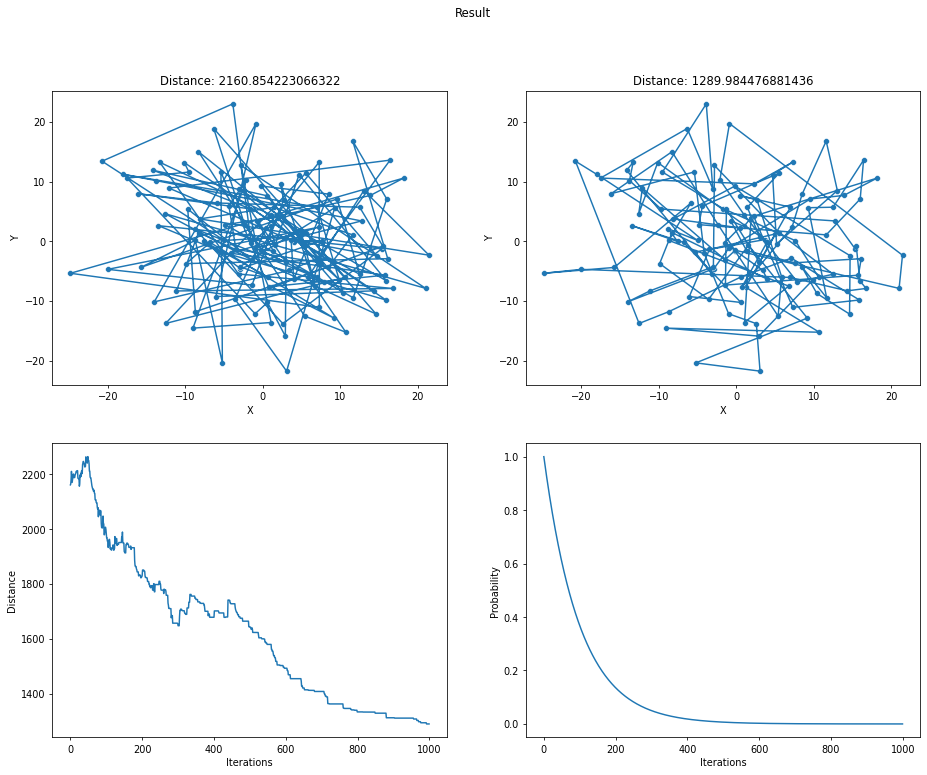

In [406]:
for _points in points_normal:
    get_answer_TSP(_points,10**3,linear=False,consecutive=False)

Wizualizacja grup dla n = 45,90,135:

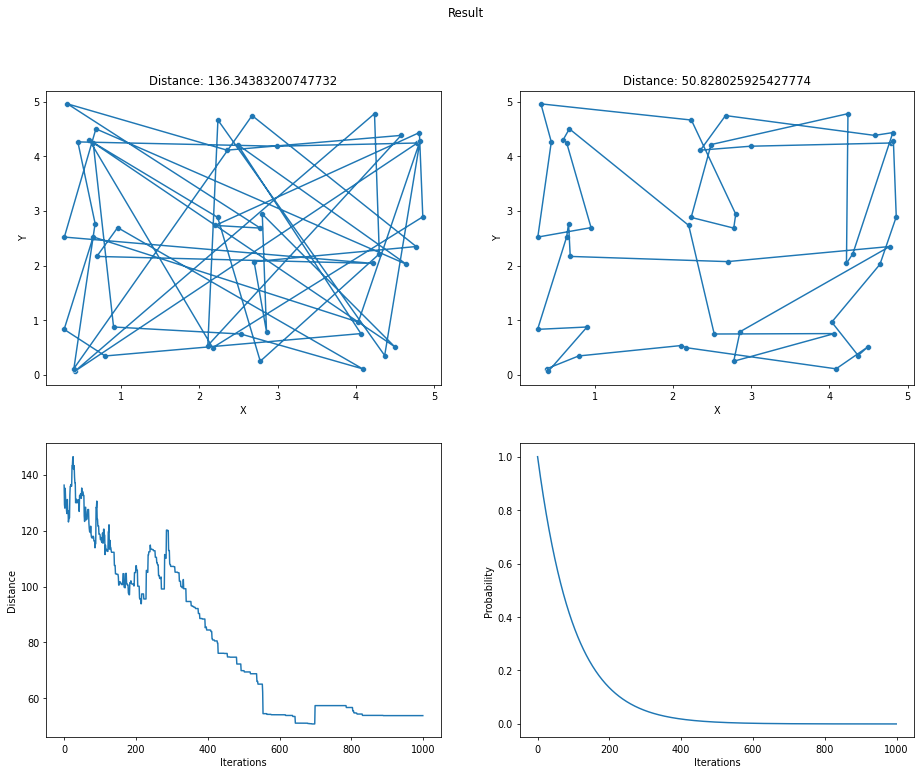

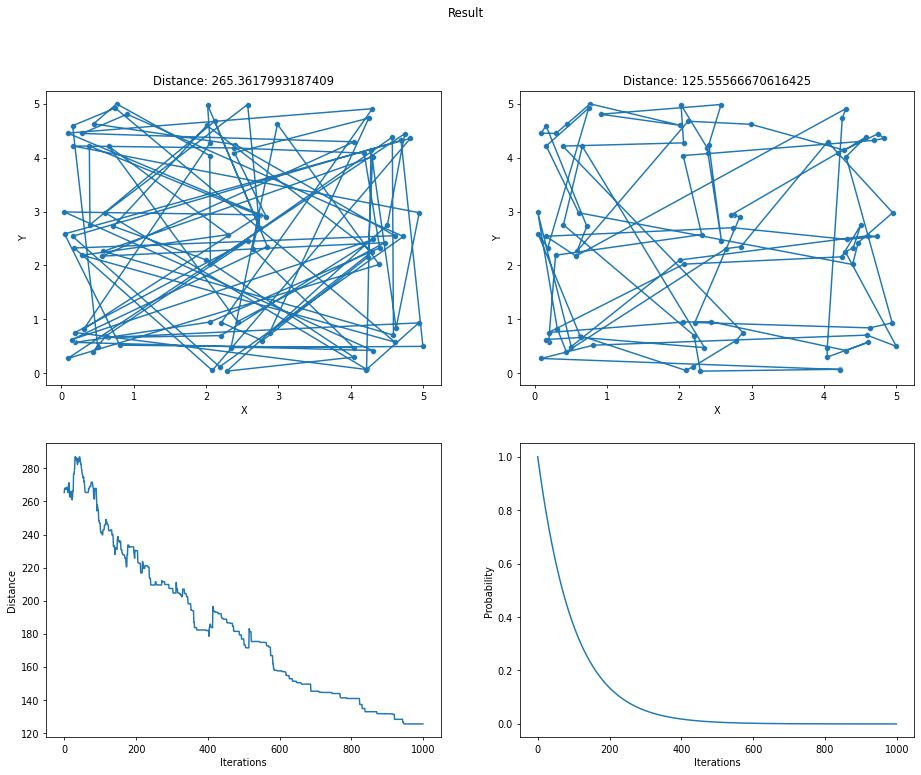

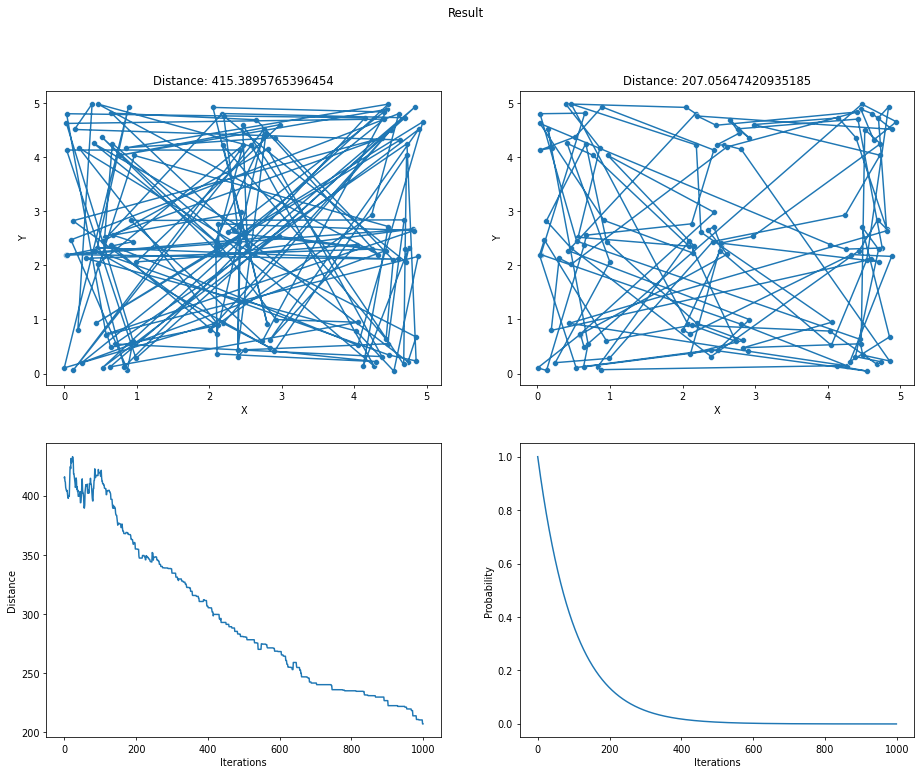

In [425]:
get_answer_TSP(group1,10**3,linear=False,consecutive=False)
get_answer_TSP(group2,10**3,linear=False,consecutive=False)
get_answer_TSP(group3,10**3,linear=False,consecutive=False)

b)  Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary
swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.

oraz

c)  Przedstaw wizualizację (saoptimset) działania procedury minimalizującej funkcję
celu.


Zależnosć miedzy consecutive swap i arbitary swap:

Consecutive iterations 10**4:

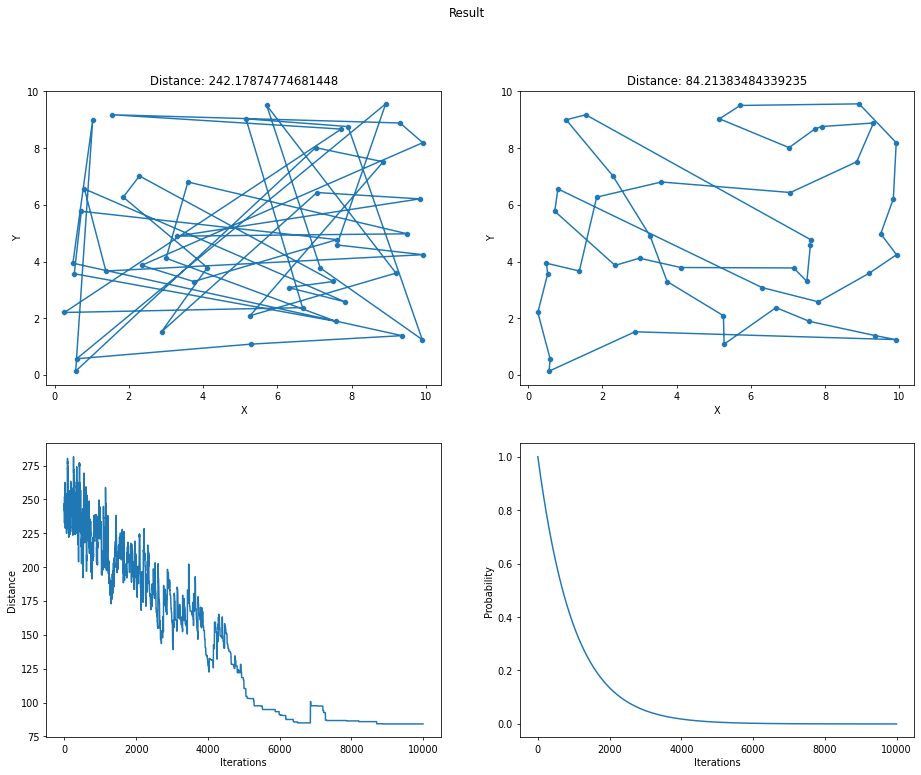

In [437]:
get_answer_TSP(points_uniform1,10**4,linear=False,consecutive=False)

Arbitary:

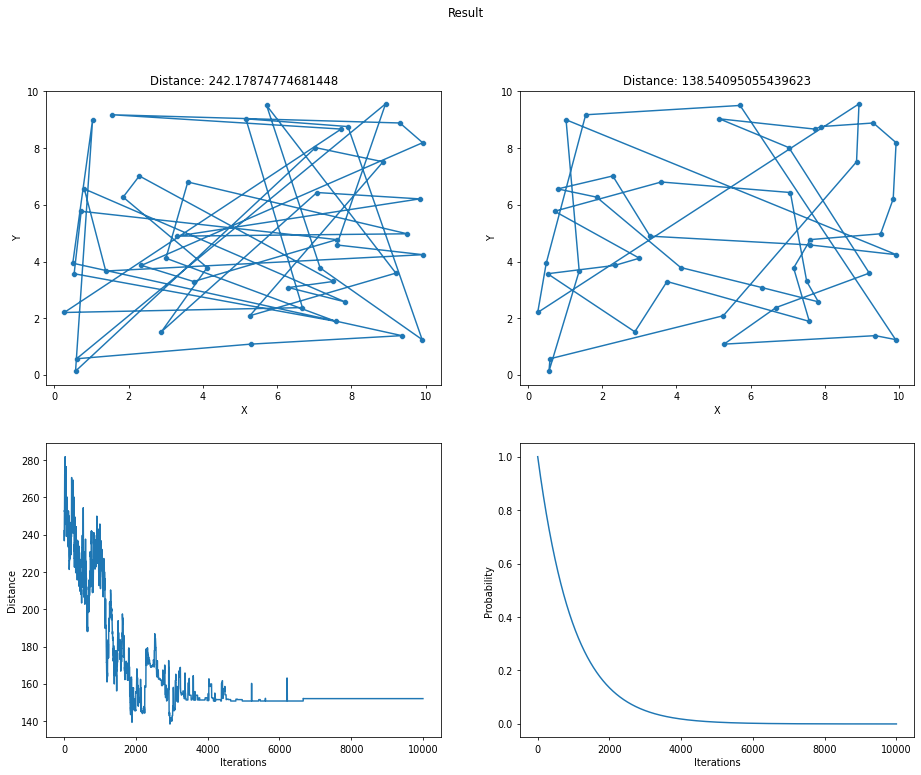

In [438]:
get_answer_TSP(points_uniform1,10**4,linear=False,consecutive=True)

Consecutive iterations 10**5:

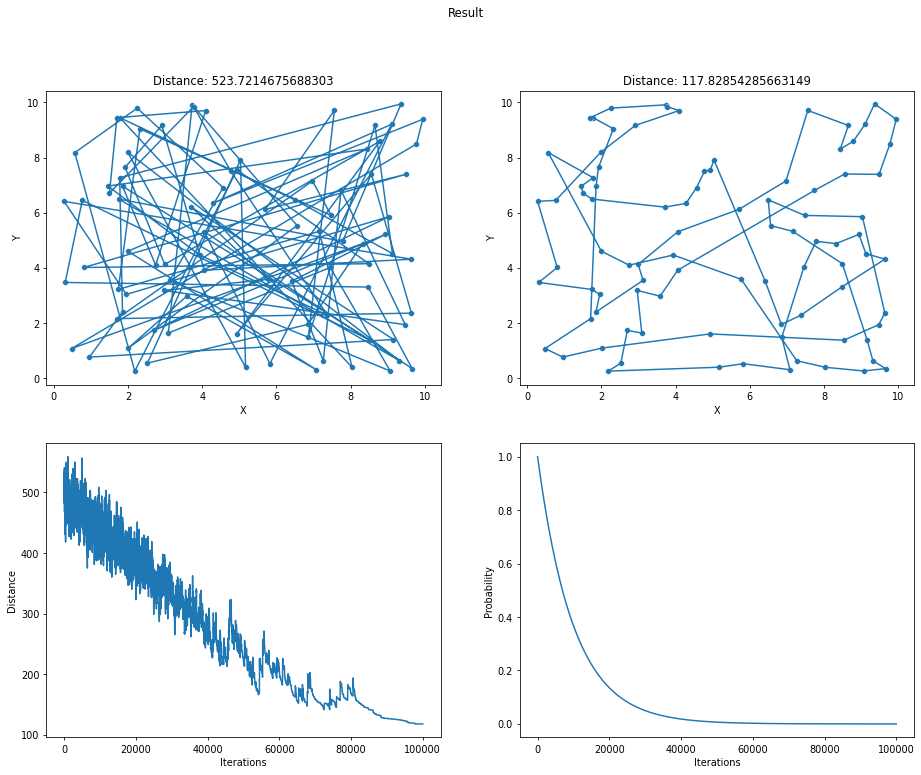

In [439]:
get_answer_TSP(points_uniform2,10**5,linear=False,consecutive=False)

Arbitary:

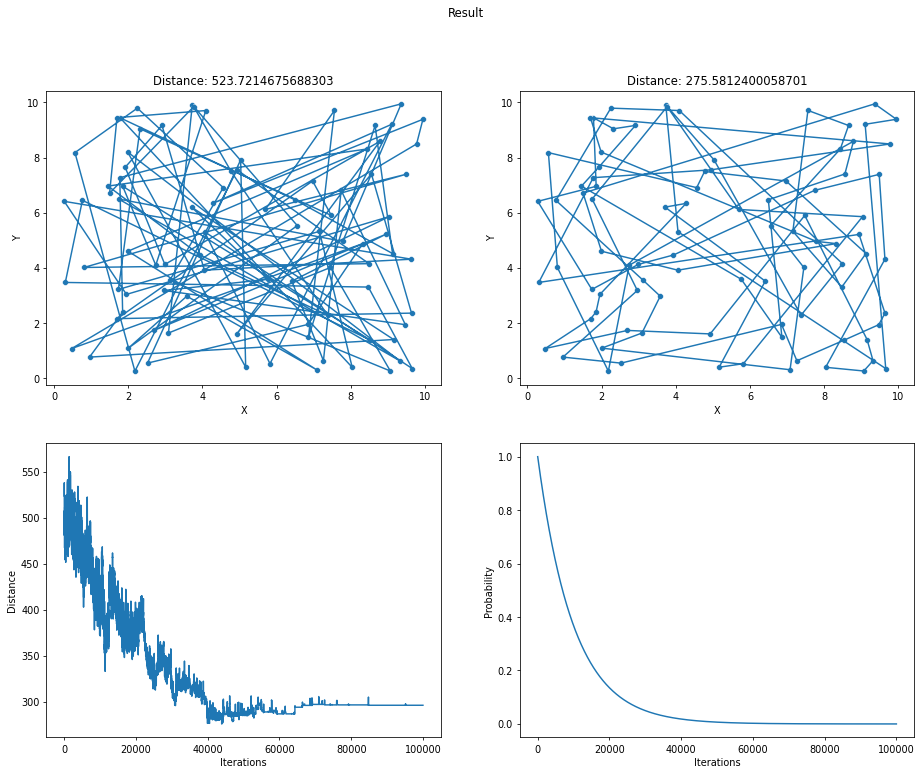

In [440]:
get_answer_TSP(points_uniform2,10**5,linear=False,consecutive=True)

Zmiana temperatury w funkcji exp na -100:

Consecutive:

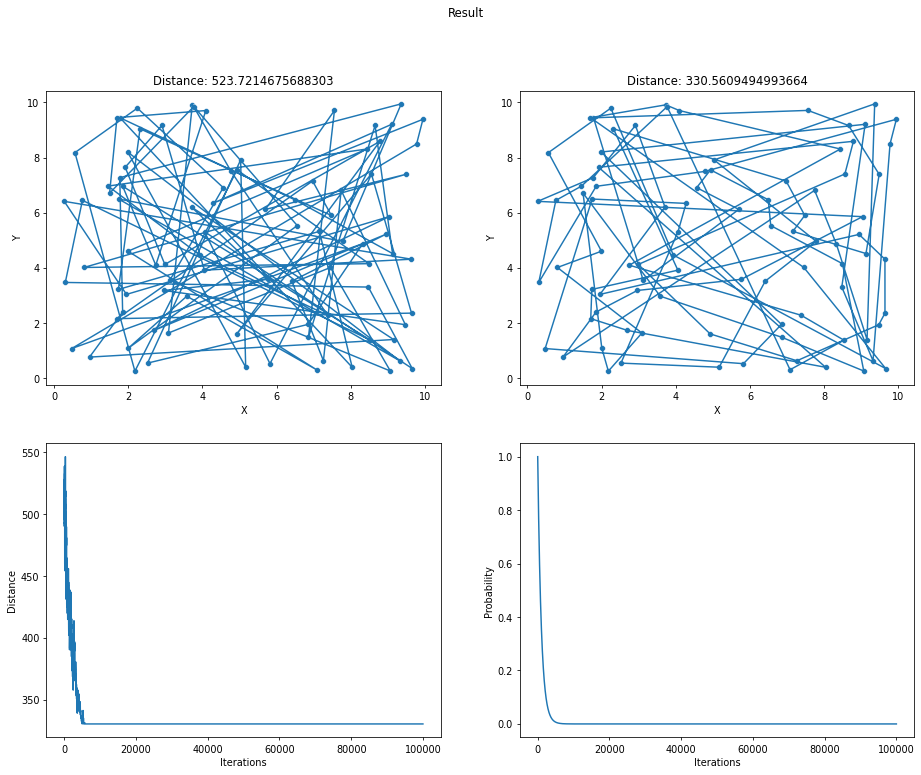

In [442]:
get_answer_TSP(points_uniform2,10**5,linear=False,consecutive=True,min_temp = -100)

Arbitary:

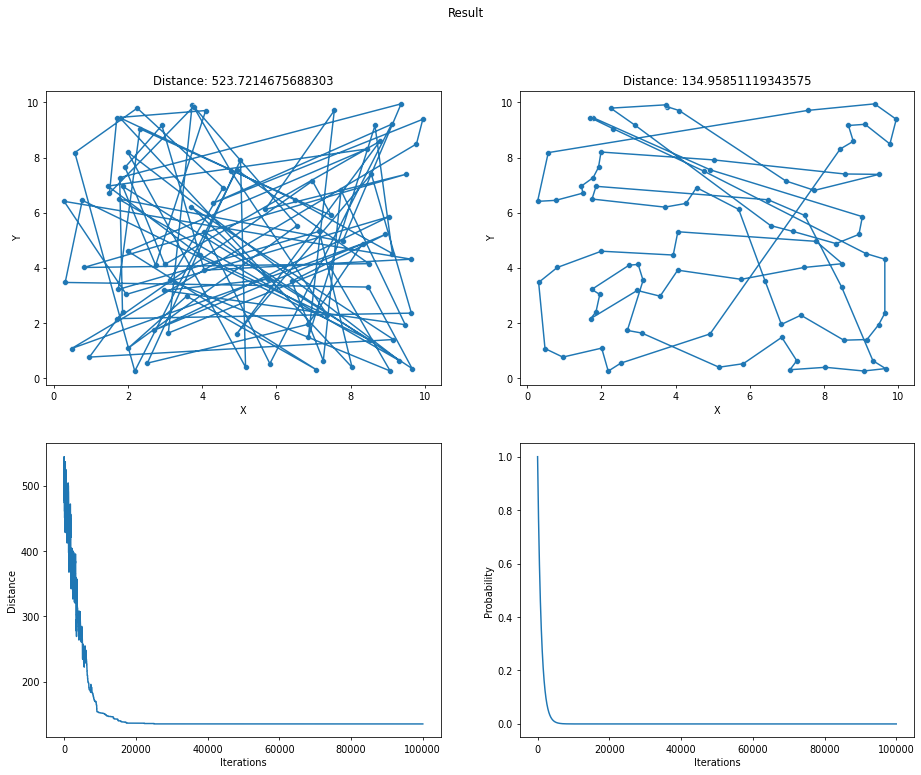

In [443]:
get_answer_TSP(points_uniform2,10**5,linear=False,consecutive=False,min_temp = -100)


Dodatkowo sprawdzmy jak zachowuje sie funkcja liniowa:

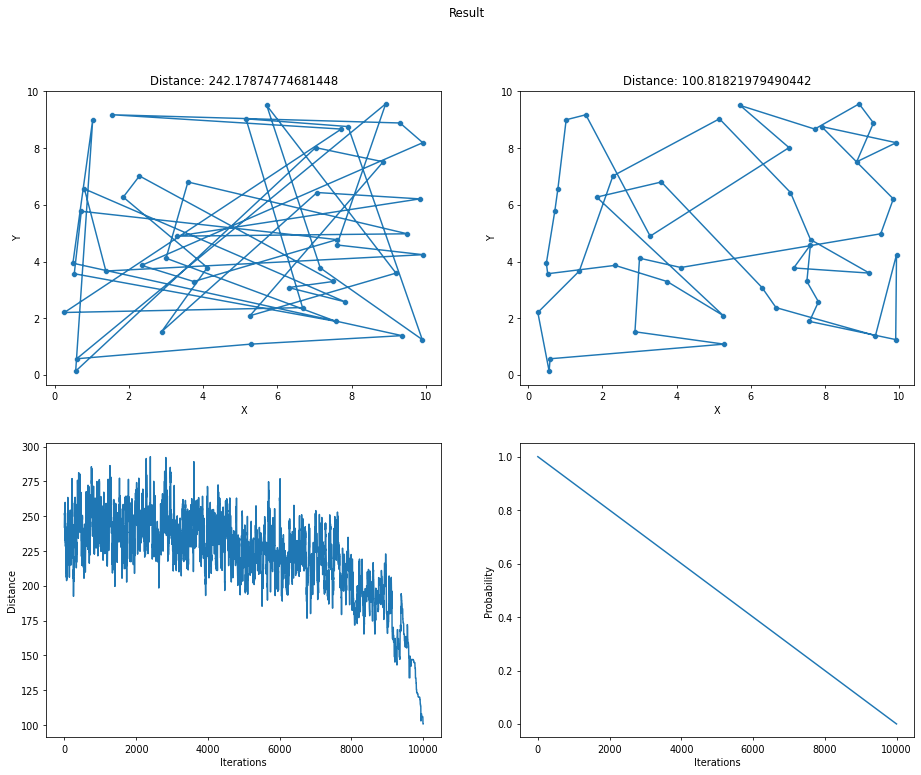

In [883]:
get_answer_TSP(points_uniform1,10**4,linear=True,consecutive=False)



Wnioski:

Funkcja liniowa potrzebuje 10-krotnie wiecej iteracji aby wyszla podobnie
co arbitrary swap

Dodatkowo funkcja liniowa ma trudnosci z stabilizowaniem sie, przez co jest duza
szansa ze majac bardzo dobre wyniki wciaz otrzymujemy bardzo slabe ze
wzledu na te wahania

Abritrary swap jest znacznie wydajniejszy i duzo lepsze wyniki daje
niz consecutive swap

Na poprzednich rysunkach mozemy zauwazyc, jak mamy zbyt stroma funkcje,
to rozwiazanie zatrzymuje sie w minimum lokalnym i nie potrafi z niego uciec

Dlatego tez nalezy dobierac parametry aby funkcja nie byla zbyt prosta
ale tez nie zbyt stroma



## 1.2 Obraz binarny
Wygeneruj losowy obraz binarny o rozmiarze n×n i wybranej gęstości δ czarnych punktów δ = 0.1, 0.3, 0.4. Korzystając z różnego typu sąsiedztwa (4-sąsiadów, 8-sąsiadów,
8-16-sąsiadów) zaproponuj funkcję energii (np. w bliskiej odległości te same kolory przyciągają się, a w dalszej odpychają się) i dokonaj jej minimalizacji za pomocą algorytmu
symulowanego wyżarzania. W jaki sposób można generować stany sąsiednie? Jak różnią się uzyskane wyniki w zależności od rodzaju sąsiedztwa, wybranej funkcji energii i
szybkości spadku temperatury?


Użyta funkcja to eksponencjalna z ustawiona domyślna wartoscia
Rozwiazania beda uzywac arbitrary swap ze wzgledu na to ze jest to wydajniejsze

In [700]:
def generate_image(n=256, partition=0.3, seed=100):
    matrix = np.zeros(shape = [n,n])

    indexes = round(n*n*partition)

    for i in range(indexes//n):
        matrix[i] += 1
    for j in range(indexes%n):
        matrix[indexes//n][j] += 1

    matrix2 = np.reshape(matrix,(-1,))

    # np.random.seed(seed)
    np.random.shuffle(matrix2)

    matrix2 = np.reshape(matrix,(n,n))

    return matrix2




In [701]:
generate_image()

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [781]:
class Energy():
    def __init__(self, energy=lambda x: x**2 if x>0 else 0):
        self.energy = energy
        self.method = None
        self.set_method_four()

    def set_method_four(self):
        self.method = self.four_neighbours
    def set_around(self):
        self.method = self.around
    def set_around_by_one(self):
        self.method = self.around_by_one
    def set_four_neighbours_crossed(self):
        self.method = self.four_neighbours_crossed
    def four_neighbours(self, matrix, r,c):
        n = len(matrix)
        return [(int((r+1) % n), c), (r, int((c+1) % n)), (int((r-1) % n), c), (r, int((c-1) % n))]
    def four_neighbours_crossed(self, matrix, r,c):
        n = len(matrix)
        return [(int((r+1) % n) , int((c+1) % n)), (int((r-1) % n), int((c+1) % n)), (int((r-1) % n), int((c-1) % n)), (int((r+1) % n), int((c-1) % n))]
    def around(self,matrix,r,c):
        return self.four_neighbours(matrix, r, c) + self.four_neighbours_crossed(matrix, r, c)
    def around_by_one(self,matrix,r,c):
        n = len(matrix)
        ans = [(int((r-2)%n), int(i % n)) for i in range(c-2, c+2+1)]
        ans += [(int(i%n), int((c+2) % n)) for i in range(r-1, r+1+1)]
        ans += [(int(i%n), int((c-2) % n)) for i in range(r-1, r+1+1)]
        ans += [(int((r+2)%n), int(i % n)) for i in range(c-2, c+2+1)]
        return ans
    def get_energy(self,number):
        return self.energy(number)

    def set_energy(self, given_func):
        self.energy = given_func


    def calculate_active_neighbours(self, matrix, r, c):
        # print(r,c)
        neighbours = self.method(matrix, r, c)
        return sum(map(lambda cords: matrix[cords[0], cords[1]], neighbours))


In [782]:
class BinaryImage():
    def __init__(self,image,iterations,method="four"):
        self.image = image
        self.n = len(image)
        self.iterations = iterations
        self.best_image = np.copy(image)
        self.start_order = np.copy(image)
        self.ene = Energy()
        self.results = []
        self.temp = Temperature(iterations,-10)
        if method == "four":
            self.ene.set_method_four()
        elif method == "around":
            self.ene.set_around()
        elif method == "around_one":
            self.ene.set_around_by_one()
        elif method == "crossed":
            self.ene.set_four_neighbours_crossed()
        self.neighbours_matrix = None
        self.best_energy = None
        self.starting_energy = None
        self.calculate_beginning_energies()

    def calculate_beginning_energies(self):
        self.neighbours_matrix = self.calculate_neighbours()
        vfunc = np.vectorize(self.ene.get_energy)
        self.best_energy = np.sum(vfunc(self.neighbours_matrix))
        self.starting_energy = self.best_energy
    def solve(self):
        # for m in self.neighbours_matrix:
        #     print(m)
        current = self.best_energy
        self.results.append(current)
        for step in range(self.iterations):
            index1, index2 = np.random.choice(range(self.n**2), 2,replace = False)
            # print(index1,index2)

            cords1, cords2 = (int(index1 // self.n), int(index1 % self.n)), (int(index2 // self.n), int(index2 % self.n))
            # print(cords1,cords2)
            diff = self.calculate_difference(cords1, cords2)
            rnd = np.random.random()
            if diff > 0 or rnd < self.temp.prob:
                self.change_cords(cords1, cords2)
                current -= diff
                # print(diff)
            # return
            if current < self.best_energy:
                self.best_energy = current
                self.best_image = copy.deepcopy(self.image)
            self.temp.calculate_temp()
            self.results.append(current)

        # print(self.ene.method)
    def change_cords(self, c1, c2):
        if self.image[c1] == self.image[c2]:
            return

        neighbours1 = self.ene.method(self.image, c1[0], c1[1])
        neighbours2 = self.ene.method(self.image, c2[0], c2[1])

        change = 1 if self.image[c1] == 0 else -1
        for neighbour in neighbours1:
            self.neighbours_matrix[neighbour] += change

        for neighbour in neighbours2:
            self.neighbours_matrix[neighbour] -= change

        self.image[c1], self.image[c2] = self.image[c2], self.image[c1]
    def calculate_neighbours(self):
        active_neighbours = lambda i,j: self.ene.calculate_active_neighbours(self.image, i, j)
        neighbours = np.ndarray((self.n, self.n))
        for r in range(self.n):
            for c in range(self.n):
                neighbours[r,c] = active_neighbours(r,c)
        return neighbours
    def calculate_difference(self, c1, c2):
        # print(c1,c2)
        if self.image[c1] == self.image[c2]:
            return 0

        neighbours1 = self.ene.method(self.image, c1[0], c1[1])
        neighbours2 = self.ene.method(self.image, c2[0], c2[1])

        common_neighbours = set(neighbours1).intersection(neighbours2)
        neighbours1 = list(filter(lambda neighbour: neighbour not in common_neighbours, neighbours1))
        neighbours2 = list(filter(lambda neighbour: neighbour not in common_neighbours, neighbours2))
        results = list(map(lambda x: self.ene.get_energy(self.neighbours_matrix[x]), itertools.chain(neighbours1, neighbours2)))
        before_change = sum(results)

        change = 1 if self.image[c1] == 0 else -1

        after_change = sum(map(lambda x: self.ene.get_energy(self.neighbours_matrix[x] + change), neighbours1)) +\
                       sum(map(lambda x: self.ene.get_energy(self.neighbours_matrix[x] - change), neighbours2))

        # When chosen points are neighbours, the is a need to consider their energy change
        if c1 in neighbours2:
            before_change += self.ene.get_energy(self.neighbours_matrix[c1]) +\
                             self.ene.get_energy(self.neighbours_matrix[c2])
            after_change += self.ene.get_energy(self.neighbours_matrix[c1] - change) +\
                            self.ene.get_energy(self.neighbours_matrix[c2] + change)

        return before_change - after_change
    def initial_plot(self,ax,s):
        order = [[i,j,self.start_order[i][j]]for j in range(self.n) for i in range(self.n)]
        # print(order)
        df = pd.DataFrame(order,columns = ["X","Y","Color"])
        # print(df)
        sns.scatterplot(ax=ax,data = df,x = "X",y="Y",hue="Color",palette=['red','black'],s=s)
        ax.set_xlim(-1, self.n)
        ax.set_ylim(-1, self.n)
    def ending_plot(self,ax,s):
        order = [[i,j,self.best_image[i][j]]for j in range(self.n) for i in range(self.n)]
        # print(order)
        df = pd.DataFrame(order,columns = ["X","Y","Color"])
        # print(df)
        sns.scatterplot(ax=ax,data = df,x = "X",y="Y",hue="Color",palette=['red','black'],s=s)
        ax.set_xlim(-1, self.n)
        ax.set_ylim(-1, self.n)

    def probability_plot(self,ax):
        df = pd.DataFrame([[i,self.temp.stash_prob[i]] for i in range(self.iterations)],columns = ["Iterations","Probability"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Probability")

    def distance_plot(self,ax):
        df = pd.DataFrame([[i,self.results[i]] for i in range(self.iterations)],columns = ["Iterations","Energy"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Energy")
        # plt.show()
    def draw_both(self,s):
        fig, axes = plt.subplots(2, 2, figsize=(16,12),dpi=70)
        self.initial_plot(axes[0][0],s)
        # self.initial_plot(axes[0][0])
        axes[0][0].set_title(f'Energy: {self.starting_energy}')
        self.ending_plot(axes[0][1],s)
        axes[0][1].set_title(f'Energy: {self.best_energy}')
        self.distance_plot(axes[1][0])
        self.probability_plot(axes[1][1])
        fig.suptitle('Result')
        plt.show()

In [772]:
def get_answer_BinaryImage(iterations,n,p,s,method="four"):
    image = generate_image(n,p)
    binImage = BinaryImage(image,iterations,method)
    binImage.solve()
    binImage.draw_both(s)

Sąsiedztwo zostało zdefiniowane jako najbliżsi sąsiedzi w bok
tzn : prawo,lewo,góra,dół

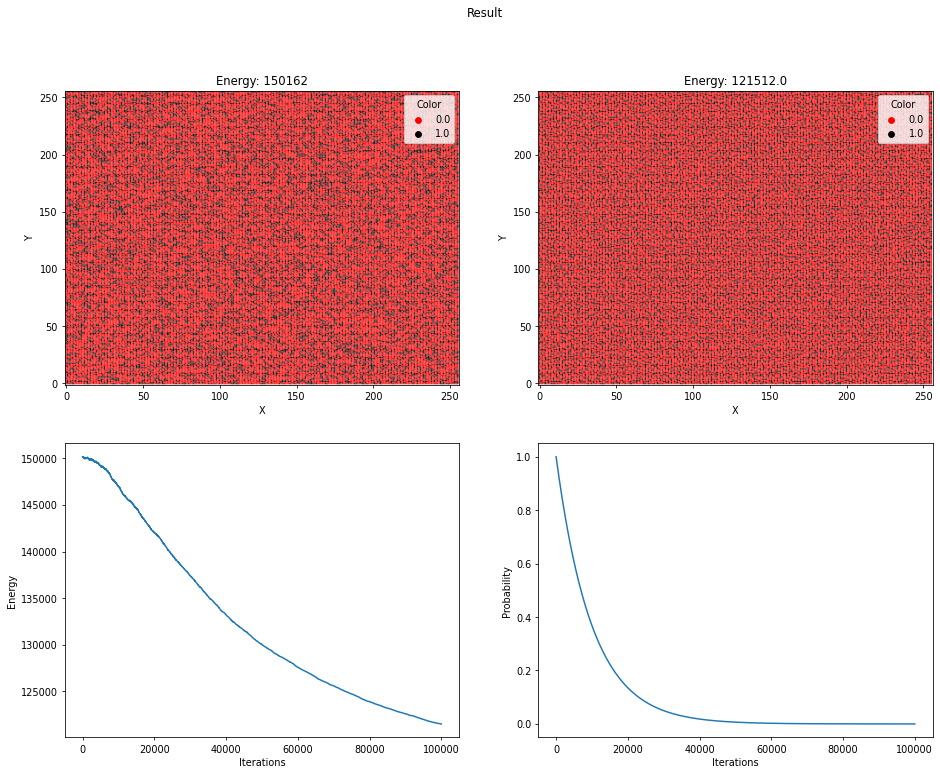

In [762]:
get_answer_BinaryImage(10**5,256,0.3,5)

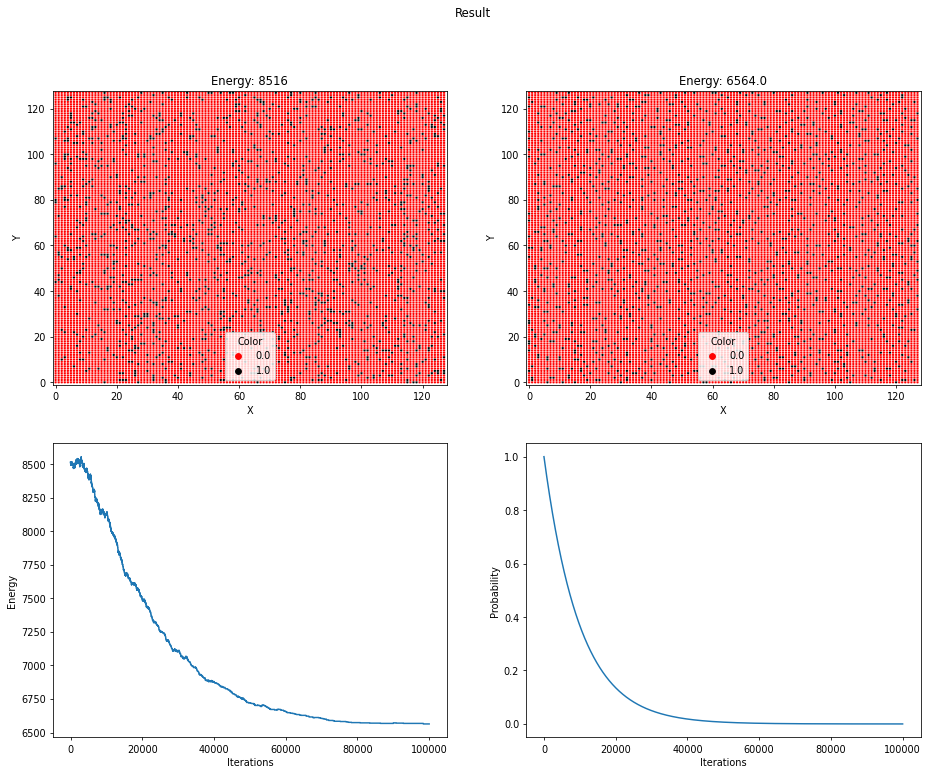

In [768]:
get_answer_BinaryImage(10**5,128,0.1,9)

Sąsiedztwo zostało zdefiniowane jako najbliżsi sąsiedzi na wokoło kratki

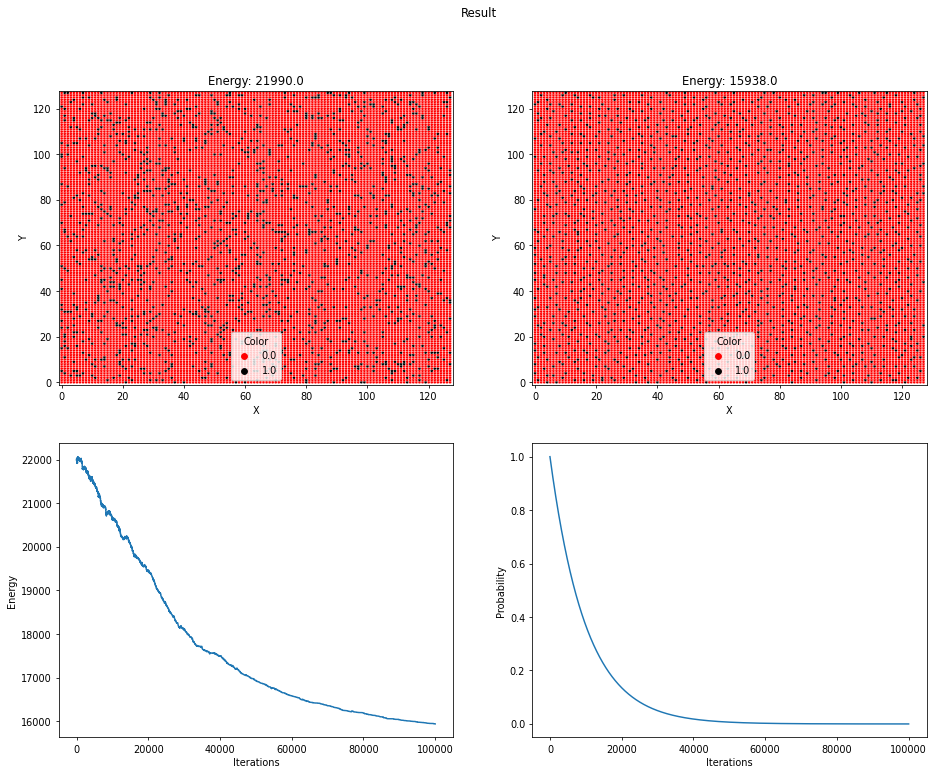

In [775]:
get_answer_BinaryImage(10**5,128,0.1,9,"around")


Sąsiedztwo zostało zdefiniowane jako najbliżsi sasiedzi na wokolo
ale okrag jest oddalony od kratki o 1

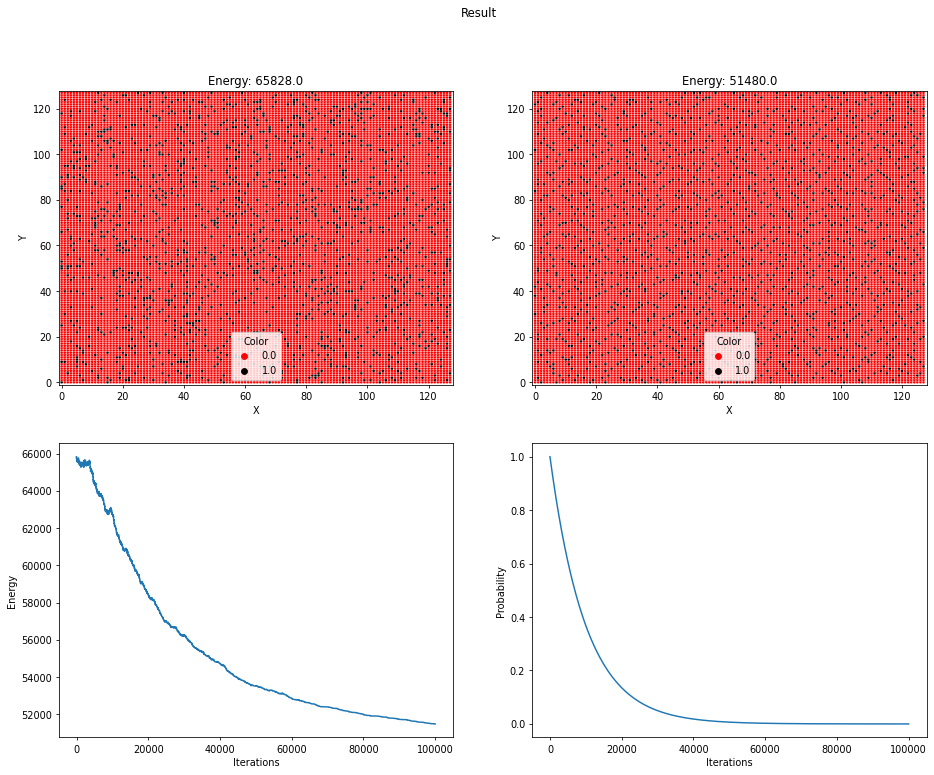

In [780]:
get_answer_BinaryImage(10**5,128,0.1,9,"around_one")


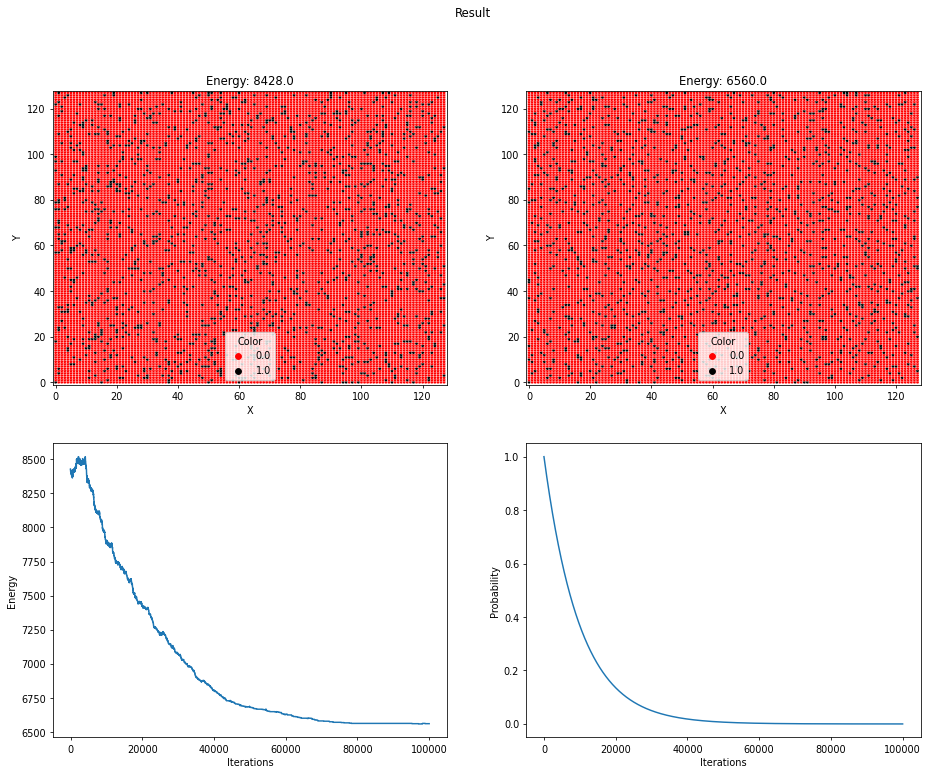

In [784]:
get_answer_BinaryImage(10**5,128,0.1,10,"crossed")

Wnioski:

Generalnie funkcja temperatury bardzo podobnie spada niezaleznie od
ustawionego sasiedztwa w przypadku oczywiscie tych wymienionych powyzej

Jak mozemy zauwazyc na wykresie Energii, koszta nieznacznie sie zmieniaja
bardzo niewielkie zmiany zachodza lub tez iteracje bardzo dobrze poprawiaja koszt energii

Na przedostatnim wykresie mozna zauwazyc jak bardzo ładnie czarne kropki
sa odseparowane co jest zalezne od funkcji jak i koszta zmalaly



## 1.3 Sudoku
Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego
wyżarzania. Plansza 9 × 9 ma zostać wczytana z pliku tekstowego, w którym pola puste
zaznaczone są znakiem x. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występujących w wierszach bloku 9 × 9, kolumnach bloku 9 × 9 oraz blokach 3 × 3. Zaproponuj
metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od
liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne
rozwiązanie dla każdej z testowanych konfiguracji wejściowych?

Wczytywanie z pliku sudoku

In [801]:
def get_matrix_from_file(file_name='sudoku.txt'):
    with open(f"sudoku/{file_name}", 'r') as f:
        lines = [line[:-1] for line in f]
        sudoku = np.array([[int(num) if num != 'x' else np.NAN for num in line.split(',')] for line in lines])

    return sudoku

In [802]:
get_matrix_from_file()

array([[nan, nan, nan,  2.,  6., nan,  7., nan,  1.],
       [ 6.,  8., nan, nan,  7., nan, nan,  9., nan],
       [ 1.,  9., nan, nan, nan,  4.,  5., nan, nan],
       [ 8.,  2., nan,  1., nan, nan, nan,  4., nan],
       [nan, nan,  4.,  6., nan,  2.,  9., nan, nan],
       [nan,  5., nan, nan, nan,  3., nan,  2.,  8.],
       [nan, nan,  9.,  3., nan, nan, nan,  7.,  4.],
       [nan,  4., nan, nan,  5., nan, nan,  3.,  6.],
       [ 7., nan,  3., nan,  1.,  8., nan, nan, nan]])

In [858]:
class SudokuCost:
    def __init__(self, cost=lambda x: x-1 if x > 1 else 0):
        self.cost = cost

    def calculate_cost(self, arr):
        counts = list(Counter(arr).values())
        return sum(map(self.cost, counts))

    def calculate_rectangle(self, matrix):
        return self.calculate_cost(matrix.flatten())


In [879]:
class Sudoku():
    def __init__(self,sudoku,iterations):
        self.Temp = Temperature(iterations,-10)
        self.iterations = iterations
        self.n = 9
        self.starting_sudoku = np.copy(sudoku)
        self.nans_indexes = self.generate_nan_indexes()
        self.sudoku = np.copy(sudoku)
        self.unused_vals_by_rows = self.create_unused_vals_by_rows()
        self.create_initial_solution()
        self.initial_sudoku = np.copy(self.sudoku)
        self.best_sudoku = np.copy(self.sudoku)
        self.cost = SudokuCost()
        self.best_cost = self.calculate_beginning_cost()
        self.starting_cost = self.best_cost
        self.results = []
    def create_unused_vals_by_rows(self):
        unused_vals_by_row = dict()
        for i in range(9):
            unused_vals_by_row[i] = [value for value in range(1,10) if value not in self.sudoku[i]]

        return unused_vals_by_row
    def generate_nan_indexes(self):
        rows, cols = np.where(np.isnan(self.starting_sudoku))
        return [(rows[i], cols[i]) for i in range(len(rows))]
    def calculate_beginning_cost(self):
        cost = 0
        for i in range(self.n):
            cost += self.cost.calculate_cost(self.sudoku[i])
            cost += self.cost.calculate_cost(self.sudoku[:, i])
            cost += self.cost.calculate_rectangle(self.sudoku[3*(i//3) : 3 + 3*(i//3), 3*(i%3) : 3 + 3*(i%3)])

        return cost
    def create_initial_solution(self):
        unused_vals_by_rows = copy.deepcopy(self.unused_vals_by_rows)
        for cord in self.nans_indexes:
            self.sudoku[cord] = unused_vals_by_rows[cord[0]].pop(np.random.randint(len(unused_vals_by_rows[cord[0]])))
    def generate_nans_indexes_by_rows(self):
        nan_indexes_by_rows = defaultdict(list)
        for indexes in self.nans_indexes:
            nan_indexes_by_rows[indexes[0]].append(indexes)

        filtered = dict()
        for row in nan_indexes_by_rows:
            if len(nan_indexes_by_rows[row]) >= 2: filtered[row] = nan_indexes_by_rows[row]

        return filtered
    def solve(self):
        nan_indexes_by_rows = self.generate_nans_indexes_by_rows()
        current = self.best_cost
        self.results.append(current)
        for step in range(self.iterations):

            if np.isclose(self.best_cost,0):
                break

            row_choice = np.random.randint(len(nan_indexes_by_rows))
            row_indexes = list(nan_indexes_by_rows.values())[row_choice]

            id1, id2 = np.random.choice(range(len(row_indexes)), 2, replace=False)
            indexes1, indexes2 = row_indexes[id1], row_indexes[id2]

            cost_difference = self.calc_diff(indexes1, indexes2)

            rnd = np.random.random()
            if cost_difference > 0 or rnd < self.Temp.prob:
                self.sudoku[indexes1], self.sudoku[indexes2] = self.sudoku[indexes2], self.sudoku[indexes1]
                current -= cost_difference

            if self.best_cost > current:
                self.best_cost = current
                self.best_sudoku = np.copy(self.sudoku)

            self.Temp.calculate_temp()
            self.results.append(current)

    def calc_diff(self, indexes1, indexes2):
        r1, c1 = indexes1
        r2, c2 = indexes2

        difference = 0
        col1, col2 = np.copy(self.sudoku[:, c1]), np.copy(self.sudoku[:, c2])
        rectangle1 = np.copy(self.sudoku[(r1//3)*3: (r1//3)*3 + 3, (c1//3)*3: (c1//3)*3 + 3])
        rectangle2 = np.copy(self.sudoku[(r2//3)*3: (r2//3)*3 + 3, (c2//3)*3: (c2//3)*3 + 3])

        rectangles_equals = False
        if c1//3 == c2//3: rectangles_equals = True

        difference += self.cost.calculate_cost(col1) + self.cost.calculate_cost(col2)
        difference += self.cost.calculate_rectangle(rectangle1)
        if not rectangles_equals:
            difference += self.cost.calculate_rectangle(rectangle2)

        col1[r1] = self.sudoku[indexes2]
        rectangle1[r1%3, c1%3] = self.sudoku[indexes2]

        col2[r1] = self.sudoku[indexes1]
        if rectangles_equals:
            rectangle1[r2%3, c2%3] = self.sudoku[indexes1]
        else:
            rectangle2[r2%3, c2%3] = self.sudoku[indexes1]

        difference -= (self.cost.calculate_cost(col1) + self.cost.calculate_cost(col2))
        difference -= self.cost.calculate_rectangle(rectangle1)
        if not rectangles_equals:
            difference -= self.cost.calculate_rectangle(rectangle2)

        return difference

    def probability_plot(self,ax):
        df = pd.DataFrame([[i,self.Temp.stash_prob[i]] for i in range(len(self.Temp.stash_prob))],columns = ["Iterations","Probability"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Probability")

    def distance_plot(self,ax):
        df = pd.DataFrame([[i,self.results[i]] for i in range(len(self.results))],columns = ["Iterations","Cost"])
        sns.lineplot(ax=ax,data = df,x = "Iterations",y="Cost")
        # plt.show()
    def draw_both(self):
        # print()
        fig, axes = plt.subplots(1, 2, figsize=(16,7),dpi=70)
        self.distance_plot(axes[0])
        self.probability_plot(axes[1])
        fig.suptitle('Result')
        plt.show()
    def print_answer(self):
        print(f'Initial Cost: {self.starting_cost}')
        for row in self.initial_sudoku:
            print(row)
        print(f'Best Cost: {self.best_cost}')
        for row in self.best_sudoku:
            print(row)

In [870]:
def get_sudoku(iterations,file_name="sudoku.txt"):
    matrix = get_matrix_from_file(file_name)
    sudoku = Sudoku(matrix, iterations)
    sudoku.solve()
    sudoku.print_answer()
    sudoku.draw_both()

Initial Cost: 47
[4. 8. 3. 2. 6. 5. 7. 9. 1.]
[6. 8. 2. 5. 7. 4. 1. 9. 3.]
[1. 9. 6. 8. 3. 4. 5. 7. 2.]
[8. 2. 9. 1. 3. 7. 5. 4. 6.]
[5. 1. 4. 6. 8. 2. 9. 7. 3.]
[1. 5. 4. 6. 7. 3. 9. 2. 8.]
[5. 2. 9. 3. 6. 8. 1. 7. 4.]
[2. 4. 7. 8. 5. 9. 1. 3. 6.]
[7. 4. 3. 9. 1. 8. 6. 2. 5.]
Best Cost: 0
[4. 3. 5. 2. 6. 9. 7. 8. 1.]
[6. 8. 2. 5. 7. 1. 4. 9. 3.]
[1. 9. 7. 8. 3. 4. 5. 6. 2.]
[8. 2. 6. 1. 9. 5. 3. 4. 7.]
[3. 7. 4. 6. 8. 2. 9. 1. 5.]
[9. 5. 1. 7. 4. 3. 6. 2. 8.]
[5. 1. 9. 3. 2. 6. 8. 7. 4.]
[2. 4. 8. 9. 5. 7. 1. 3. 6.]
[7. 6. 3. 4. 1. 8. 2. 5. 9.]


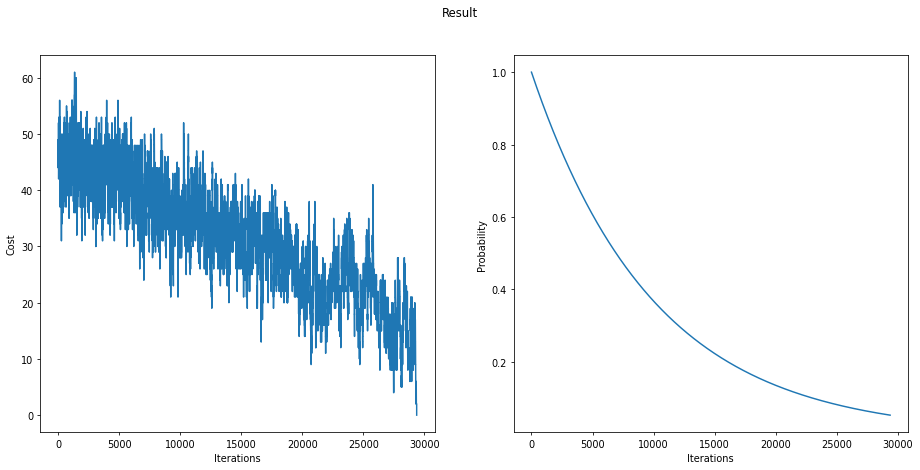

In [880]:
get_sudoku(10**5)

Initial Cost: 48
[9. 6. 3. 8. 1. 5. 2. 4. 7.]
[6. 8. 1. 3. 5. 7. 4. 9. 2.]
[6. 8. 2. 7. 3. 9. 5. 1. 4.]
[5. 7. 2. 4. 6. 1. 8. 9. 3.]
[6. 4. 3. 9. 2. 1. 8. 5. 7.]
[7. 6. 8. 9. 2. 1. 3. 4. 5.]
[2. 4. 5. 1. 9. 7. 6. 8. 3.]
[6. 9. 1. 4. 2. 3. 5. 7. 8.]
[7. 2. 6. 5. 9. 8. 4. 3. 1.]
Best Cost: 4
[9. 3. 7. 6. 1. 5. 2. 8. 4.]
[5. 8. 1. 2. 4. 7. 3. 9. 6.]
[6. 4. 2. 3. 8. 9. 5. 1. 7.]
[2. 7. 9. 5. 6. 4. 8. 3. 1.]
[4. 5. 3. 9. 8. 1. 7. 6. 2.]
[1. 6. 8. 7. 2. 3. 9. 4. 5.]
[7. 4. 5. 1. 9. 8. 6. 2. 3.]
[3. 9. 2. 4. 5. 6. 1. 7. 8.]
[8. 1. 6. 7. 3. 2. 4. 5. 9.]


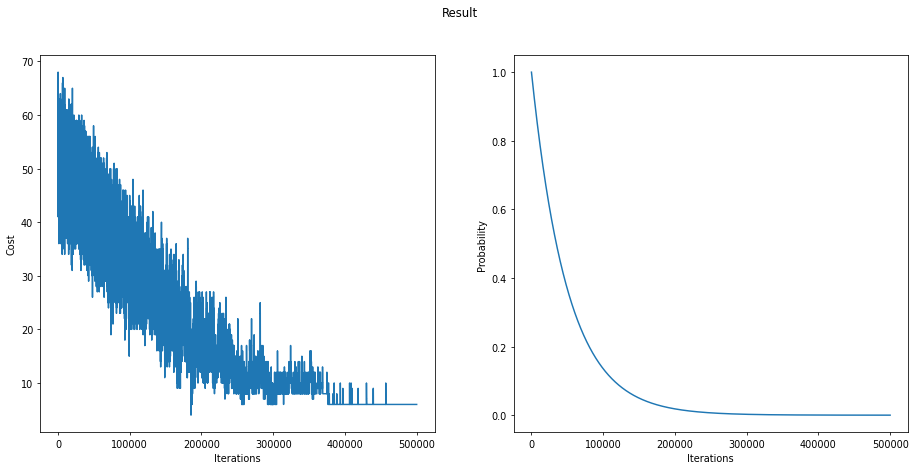

In [881]:
get_sudoku(5*10**5,file_name ="sudoku_hard.txt")

Wnioski:

W moim przypadku zamieniam kazde 2 miejsca w rzedach, co daje dosc dobry efekt
bo udalo sie rozwiazac 1 sudoku, a sudoku niejednoznaczne jest bliskei rozwiazaniu
,a wiec skorzystalem z arbitrary swapa miedzy dwoma miejscami w wybranym rzedzie

2 sudoku jest dosc trudne co swiadczy o bardzo słabym koszcie, ale mimo
to algorytm dosc dobrze sobie z nim radzi

Mozna by zastosowac ponowne odpalenie programu na koncowych danych z poprzedniego wyniku
aby sprobowac uzyskac poprawne rozwiazanie



